# Make signature network using the `CD_center_LM` signatures 

In [1]:
import os, sys, json
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import neighbors
from sqlalchemy import create_engine
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Plot degree distribution
def plot_degree_distribution(G):
    fig, ax = plt.subplots()
    
    degrees = G.degree().values()
    degrees = dict(Counter(degrees))
    x = degrees.keys()
    y = degrees.values()

    ax.scatter(x, y, s=10, alpha=.6)
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    return ax


In [3]:
## Load signature metadata mongodb
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000FWD']['sigs']
cur = coll.find({'SCS_centered_by_batch': {"$lt": 0.05}}, 
                {'_id':False, 
                 'sig_id':True, 
                 'SCS_centered_by_batch':True,
                 'pert_id':True,
                 'cell_id':True,
                 'pert_dose':True,
                })

sig_meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
sig_meta_df.rename(index=str,columns={'SCS_centered_by_batch':'pvalue'}, inplace=True)
print sig_meta_df.shape
sig_meta_df.head()

(48098, 4)


,pvalue,cell_id,pert_dose,pert_id
sig_id,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,0.0028,HS578T,2.0,BRD-K52911425
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,0.0483,HS578T,10.0,BRD-K69932463
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,0.0007,HS578T,10.0,BRD-K85606544
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,0.0000,HS578T,10.0,BRD-K72636697
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,0.0000,HS578T,0.4,BRD-K13390322


In [4]:
sig_meta_df['batch'] = sig_meta_df.index.map(lambda x:x.split(':')[0])
sig_meta_df['time'] = sig_meta_df['batch'].map(lambda x:x.split('_')[2].strip('H'))
sig_meta_df.to_csv('../data/metadata-L1000FWD.tsv', sep='\t')

In [5]:
# Get the top 50 significant signatures for each pert_id
def pick_top_sigs(x):
    x = x.sort_values(ascending=True)
    n_significants = (x < 0.05).sum()
    if n_significants == 0:
        return x.head(2)
    else:
        return x.head(n_significants)

grouped_sorted = sig_meta_df.groupby('pert_id')['pvalue'].apply(pick_top_sigs)
print grouped_sorted.shape
grouped_sorted.head()

(48098,)


pert_id        sig_id                                   
BRD-A00100033  CPC015_PHH_24H:BRD-A00100033-001-04-8:10     0.0203
BRD-A00267231  CPC001_PC3_6H:BRD-A00267231-001-01-1:10      0.0007
               CPC001_HA1E_24H:BRD-A00267231-001-01-1:10    0.0022
               CPC017_ASC_24H:BRD-A00267231-001-01-1:10     0.0126
               CPC017_A549_6H:BRD-A00267231-001-01-1:10     0.0228
Name: pvalue, dtype: float64

pert_id
BRD-K81418486    977
BRD-A19500257    811
BRD-A19037878    794
BRD-A75409952    696
BRD-A79768653    202
BRD-K27305650    193
BRD-K88378636    146
BRD-K59369769    139
BRD-A84481105    131
BRD-K02130563    131
BRD-K41859756    128
BRD-A58955223    116
BRD-K68202742    116
BRD-K77908580    110
BRD-K64890080    104
BRD-K87909389    100
BRD-K57080016     99
BRD-K35960502     95
BRD-K69932463     95
BRD-A61304759     94
BRD-A35588707     92
BRD-K24132293     92
BRD-A13084692     89
BRD-K64606589     88
BRD-K67868012     85
BRD-A13122391     84
BRD-K15108141     84
BRD-K71879491     84
BRD-K18910433     83
BRD-A71390734     82
BRD-K77987382     82
BRD-K85606544     82
BRD-K21680192     81
BRD-K56343971     80
BRD-A15079084     80
BRD-A90490067     80
BRD-K12502280     79
BRD-K12184916     79
BRD-A36630025     79
BRD-K36740062     78
BRD-K50140147     78
BRD-K31342827     78
BRD-K01877528     77
BRD-K92317137     77
BRD-A45889380     76
BRD-A52650764     76
BRD-K89732114     76
BRD-K

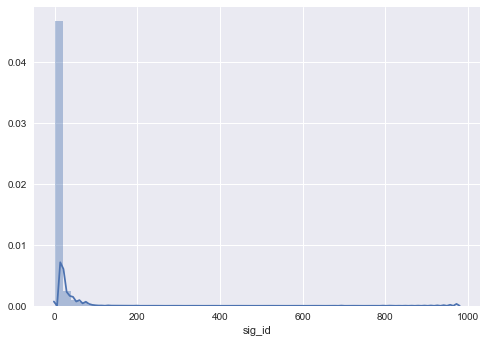

In [9]:
# filter out pert_id with less than 5 signatures
pert_id_counts = sig_meta_df.reset_index().groupby('pert_id')['sig_id'].count()
print pert_id_counts.sort_values(ascending=False)[:50]
sns.distplot(pert_id_counts)

In [ ]:
pert_ids_kept = pert_id_counts[pert_id_counts > 0].index.tolist()
# pert_ids_kept = pert_id_counts[pert_id_counts > 3].index.tolist()
print 'Number of pert_id to keep: %d' % len(pert_ids_kept)

In [12]:
grouped_sorted = grouped_sorted[pert_ids_kept].reset_index()
print grouped_sorted.shape
n_sigs = grouped_sorted.shape[0]
print 'Number of sig_id to keep: %d' % n_sigs


(48098, 3)
Number of sig_id to keep: 48098


In [9]:
grouped_sorted.head()

,pert_id,sig_id,pvalue
0,BRD-A00420644,CPC019_A549_24H:BRD-A00420644-001-01-7:10,0.0
1,BRD-A00420644,CPC019_HCC515_6H:BRD-A00420644-001-01-7:10,0.0
2,BRD-A00420644,CPC019_MCF7_6H:BRD-A00420644-001-01-7:10,0.0
3,BRD-A00420644,CPC019_VCAP_24H:BRD-A00420644-001-01-7:10,0.0
4,BRD-A00420644,CPC019_HT29_6H:BRD-A00420644-001-01-7:10,0.0


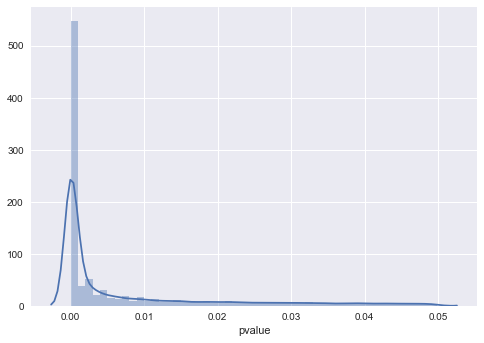

In [10]:
sns.distplot(grouped_sorted['pvalue'])

In [11]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
        if i % 5000 == 0:
            print i, len(sig_ids)
    return sig_mat

In [12]:
## Extract signature matrix
mat = retrieve_sig_mat(grouped_sorted['sig_id'], coll, 'CD_center_LM')
print mat.shape

0 34434
5000 34434
10000 34434
15000 34434
20000 34434
25000 34434
30000 34434
(34434, 978)


In [13]:
def compute_adjcency_mat(X, metric='cosine'):
    adj_mat = 1 - pairwise_distances(X, metric=metric)
    # remove 1's on the diagnal
    adj_mat -= np.eye(X.shape[0])
    ## convert negative values in adj_mat to 0's
    adj_mat[adj_mat<0] = 0    
    return adj_mat

def create_graph_by_threshold(adj_mat, percentile):
    triu_idx = np.tril_indices(adj_mat.shape[0], 1)
    thresold = np.percentile(adj_mat[triu_idx], percentile)
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<thresold] = 0
    G = nx.from_numpy_matrix(adj_mat_)
    return G

def create_knn_graph(X, k=30, metric='euclidean', n_jobs=1):
    '''Create a graph from a data matrix (sample x features).
    '''
    adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', 
                                         metric=metric,
                                         n_jobs=n_jobs
                                        )
    G = nx.from_scipy_sparse_matrix(adj_mat)
    return G


In [19]:
# Compute the pairwise cosine distance and convert to adjacency matrix
adj_mat = 1 - pairwise_distances(mat, metric='cosine',
                                n_jobs=1)
print adj_mat.shape

(34434, 34434)


In [20]:
del mat

In [27]:
k = 3

In [28]:
# Create a graph by kNN
G = create_knn_graph(mat, k=k, n_jobs=6)
print G.number_of_nodes(), G.number_of_edges()

34434 88913


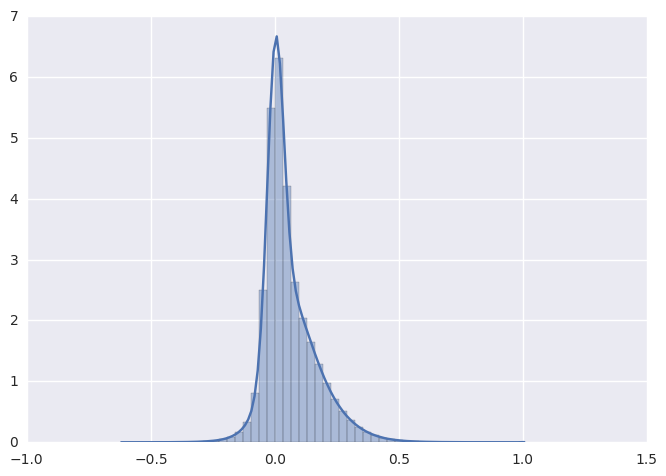

In [6]:
sns.distplot(adj_mat.ravel())

In [21]:
print adj_mat[:5, :5]

[[ 1.          0.19972239  0.11240999  0.06357018  0.27353767]
 [ 0.19972239  1.          0.24668629  0.01336093  0.30280702]
 [ 0.11240999  0.24668629  1.          0.06284576  0.26836507]
 [ 0.06357018  0.01336093  0.06284576  1.          0.07616437]
 [ 0.27353767  0.30280702  0.26836507  0.07616437  1.        ]]


In [22]:
## remove 1's on the diagnal
adj_mat = adj_mat - np.eye(adj_mat.shape[0])
## convert negative values in adj_mat to 0's
adj_mat[adj_mat<0] = 0
print adj_mat[:5, :5]

[[  2.22044605e-16   1.99722389e-01   1.12409986e-01   6.35701792e-02
    2.73537672e-01]
 [  1.99722389e-01   8.88178420e-16   2.46686287e-01   1.33609281e-02
    3.02807020e-01]
 [  1.12409986e-01   2.46686287e-01   2.22044605e-16   6.28457608e-02
    2.68365074e-01]
 [  6.35701792e-02   1.33609281e-02   6.28457608e-02   0.00000000e+00
    7.61643687e-02]
 [  2.73537672e-01   3.02807020e-01   2.68365074e-01   7.61643687e-02
    4.44089210e-16]]


In [23]:
for percent in np.arange(0,100, 5):
    print percent, np.percentile(adj_mat.ravel(), percent)

0 0.0
5 0.0
10

KeyboardInterrupt: 

99.95 0.387579934361
34434 296426


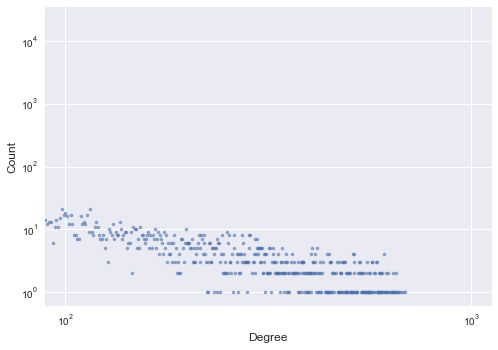

In [34]:
# Create a undirected graph from the adj_mat by first setting values smaller than cutoff to 0's 
# to control number of edges.
percentile_cutoff = 99.95
cosine_similarity_cutoff = np.percentile(adj_mat.ravel(), percentile_cutoff)

print percentile_cutoff, cosine_similarity_cutoff

adj_mat_ = adj_mat.copy()
adj_mat_[adj_mat_<cosine_similarity_cutoff] = 0

G = nx.from_numpy_matrix(adj_mat_)
del adj_mat_

print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

In [21]:
## Examine number of large connected components
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        print cc.number_of_nodes()
        print cc.nodes()[:5]

34434
[0, 1, 2, 3, 4]


In [29]:
## Create a new graph only keeping the large connected components
G_new = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)

print G_new.number_of_nodes(), G_new.number_of_edges()

34406 88865


In [30]:
# Relabel nodes with sig_ids
sig_ids_shared = grouped_sorted['sig_id'].tolist()
d_id_sig_id = dict(zip(range(len(sig_ids_shared)), sig_ids_shared))
d_id_sig_id = {nid: sig_id for nid, sig_id in d_id_sig_id.items() if G_new.has_node(nid)}
nx.relabel_nodes(G_new, d_id_sig_id, copy=False)
print G_new.nodes()[:5]

['CPC014_HCC515_6H:BRD-K50168500-001-01-2:10', 'CPC019_PC3_24H:BRD-K30849099-001-07-6:10', 'CPC004_HCC515_6H:BRD-A27554692-001-01-3:10', 'CPC006_NCIH1694_6H:BRD-K17349619-003-01-4:10', 'CPC015_NPC_24H:BRD-A72596465-001-01-3:10']


In [10]:
# nx.write_gexf(G, 'test.gexf')

In [31]:
# nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_%s.gml' % (G_new.number_of_nodes(), percentile_cutoff))
nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_kNN%d.gml' % (G_new.number_of_nodes(), k))